# Search through videos using fast.ai

This notebook will walk you through a simple example that trains a model to determine if there's a bicycle in an image and then use that to find bicycles in a video.

This work is based on the early lessons in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course.

## Using this notebook

Essentially you need a computer that's running a GPU running fast.ai. There are a few ways to do this without owning a computer with a GPU (I certainly don't). There are [lots of options](https://course.fast.ai/index.html). I like to use use [the Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is probably the most complicated. In most of these cases, you'll just clone [the workshop repository](https://github.com/Quartz/aistudio-workshops) and get the notebook running.

I'm also tailoring this notebook for use with [Google Colaboratory](https://colab.research.google.com), which as of this writing is the fastest, cheapest (free) way to get going.


### If you're using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes).

There are great steps on the fast.ai site for [getting started with fast.ai an Google Colab](https://course.fast.ai/start_colab.html). 

Those instructions will show you how to save your own copy of this _notebook_ to Google Drive.

They also tell you how to save a copy of your _data_ to Google Drive (Step 4), which is unneccesary for this workshop. 

In [1]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link '/content': Permission denied
ln: failed to create symbolic link '/content': Permission denied
Updating fastai...
You should consider upgrading via the 'pip install --upgrade pip' command.
Done.


### If you are _not_ using Google Colaboratory ...

Run the cell below.

In [6]:
## ALL OTHER USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

In [26]:
## AND EVERYBODY RUNS THIS CELL

!apt install ffmpeg

from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image as Show
from IPython.display import Video


## The Plan

The goal is to see if we can spot something specific in a video. This would be useful especially if you had hours of video you didn't have time to watch.

In our case, we'll try to spot bicycles in this video:


Our plan will be:

- Download a computer-vision model pre-trained on 14 million images
- Further train that model on images containing "yes bikes" and "no bikes"
- Chop up our video into frames
- Use the model to detect bikes in frames

## The Data

Let's get the video and the "yes bikes" and "no bikes" images, which are in the folders `1` and `0` respectively.

In [2]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
!unzip bikes_data.zip > /dev/null
print('Done!')

--2019-08-12 20:27:39--  https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
Resolving qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)... 52.216.201.27
Connecting to qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)|52.216.201.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381123163 (363M) [application/zip]
Saving to: ‘bikes_data.zip’

bikes_data.zip      100%[===================>] 363.47M  95.7MB/s    in 3.8s    

2019-08-12 20:27:43 (96.5 MB/s) - ‘bikes_data.zip’ saved [381123163/381123163]

Done!


Now you have a subdirectory called `bikes_data` which contains two folders (`0` and `1`) and the movie.

In [4]:
%ls bikes_data

0/  1/  IMG_1521.MOV


In [5]:
%ls bikes_data/1

IMG_1479.JPG  IMG_1494.JPG  IMG_1505.JPG  IMG_1519.JPG  IMG_1547.JPG
IMG_1480.JPG  IMG_1495.JPG  IMG_1506.JPG  IMG_1520.JPG  IMG_1548.JPG
IMG_1481.JPG  IMG_1497.JPG  IMG_1507.JPG  IMG_1524.JPG  IMG_1549.JPG
IMG_1482.JPG  IMG_1498.JPG  IMG_1508.JPG  IMG_1525.JPG  IMG_1550.JPG
IMG_1483.JPG  IMG_1500.JPG  IMG_1514.JPG  IMG_1526.JPG  IMG_1553.JPG
IMG_1486.JPG  IMG_1501.JPG  IMG_1515.JPG  IMG_1527.JPG
IMG_1490.JPG  IMG_1502.JPG  IMG_1516.JPG  IMG_1528.JPG
IMG_1491.JPG  IMG_1503.JPG  IMG_1517.JPG  IMG_1533.JPG
IMG_1492.JPG  IMG_1504.JPG  IMG_1518.JPG  IMG_1541.JPG


Let's take a looks at one ...

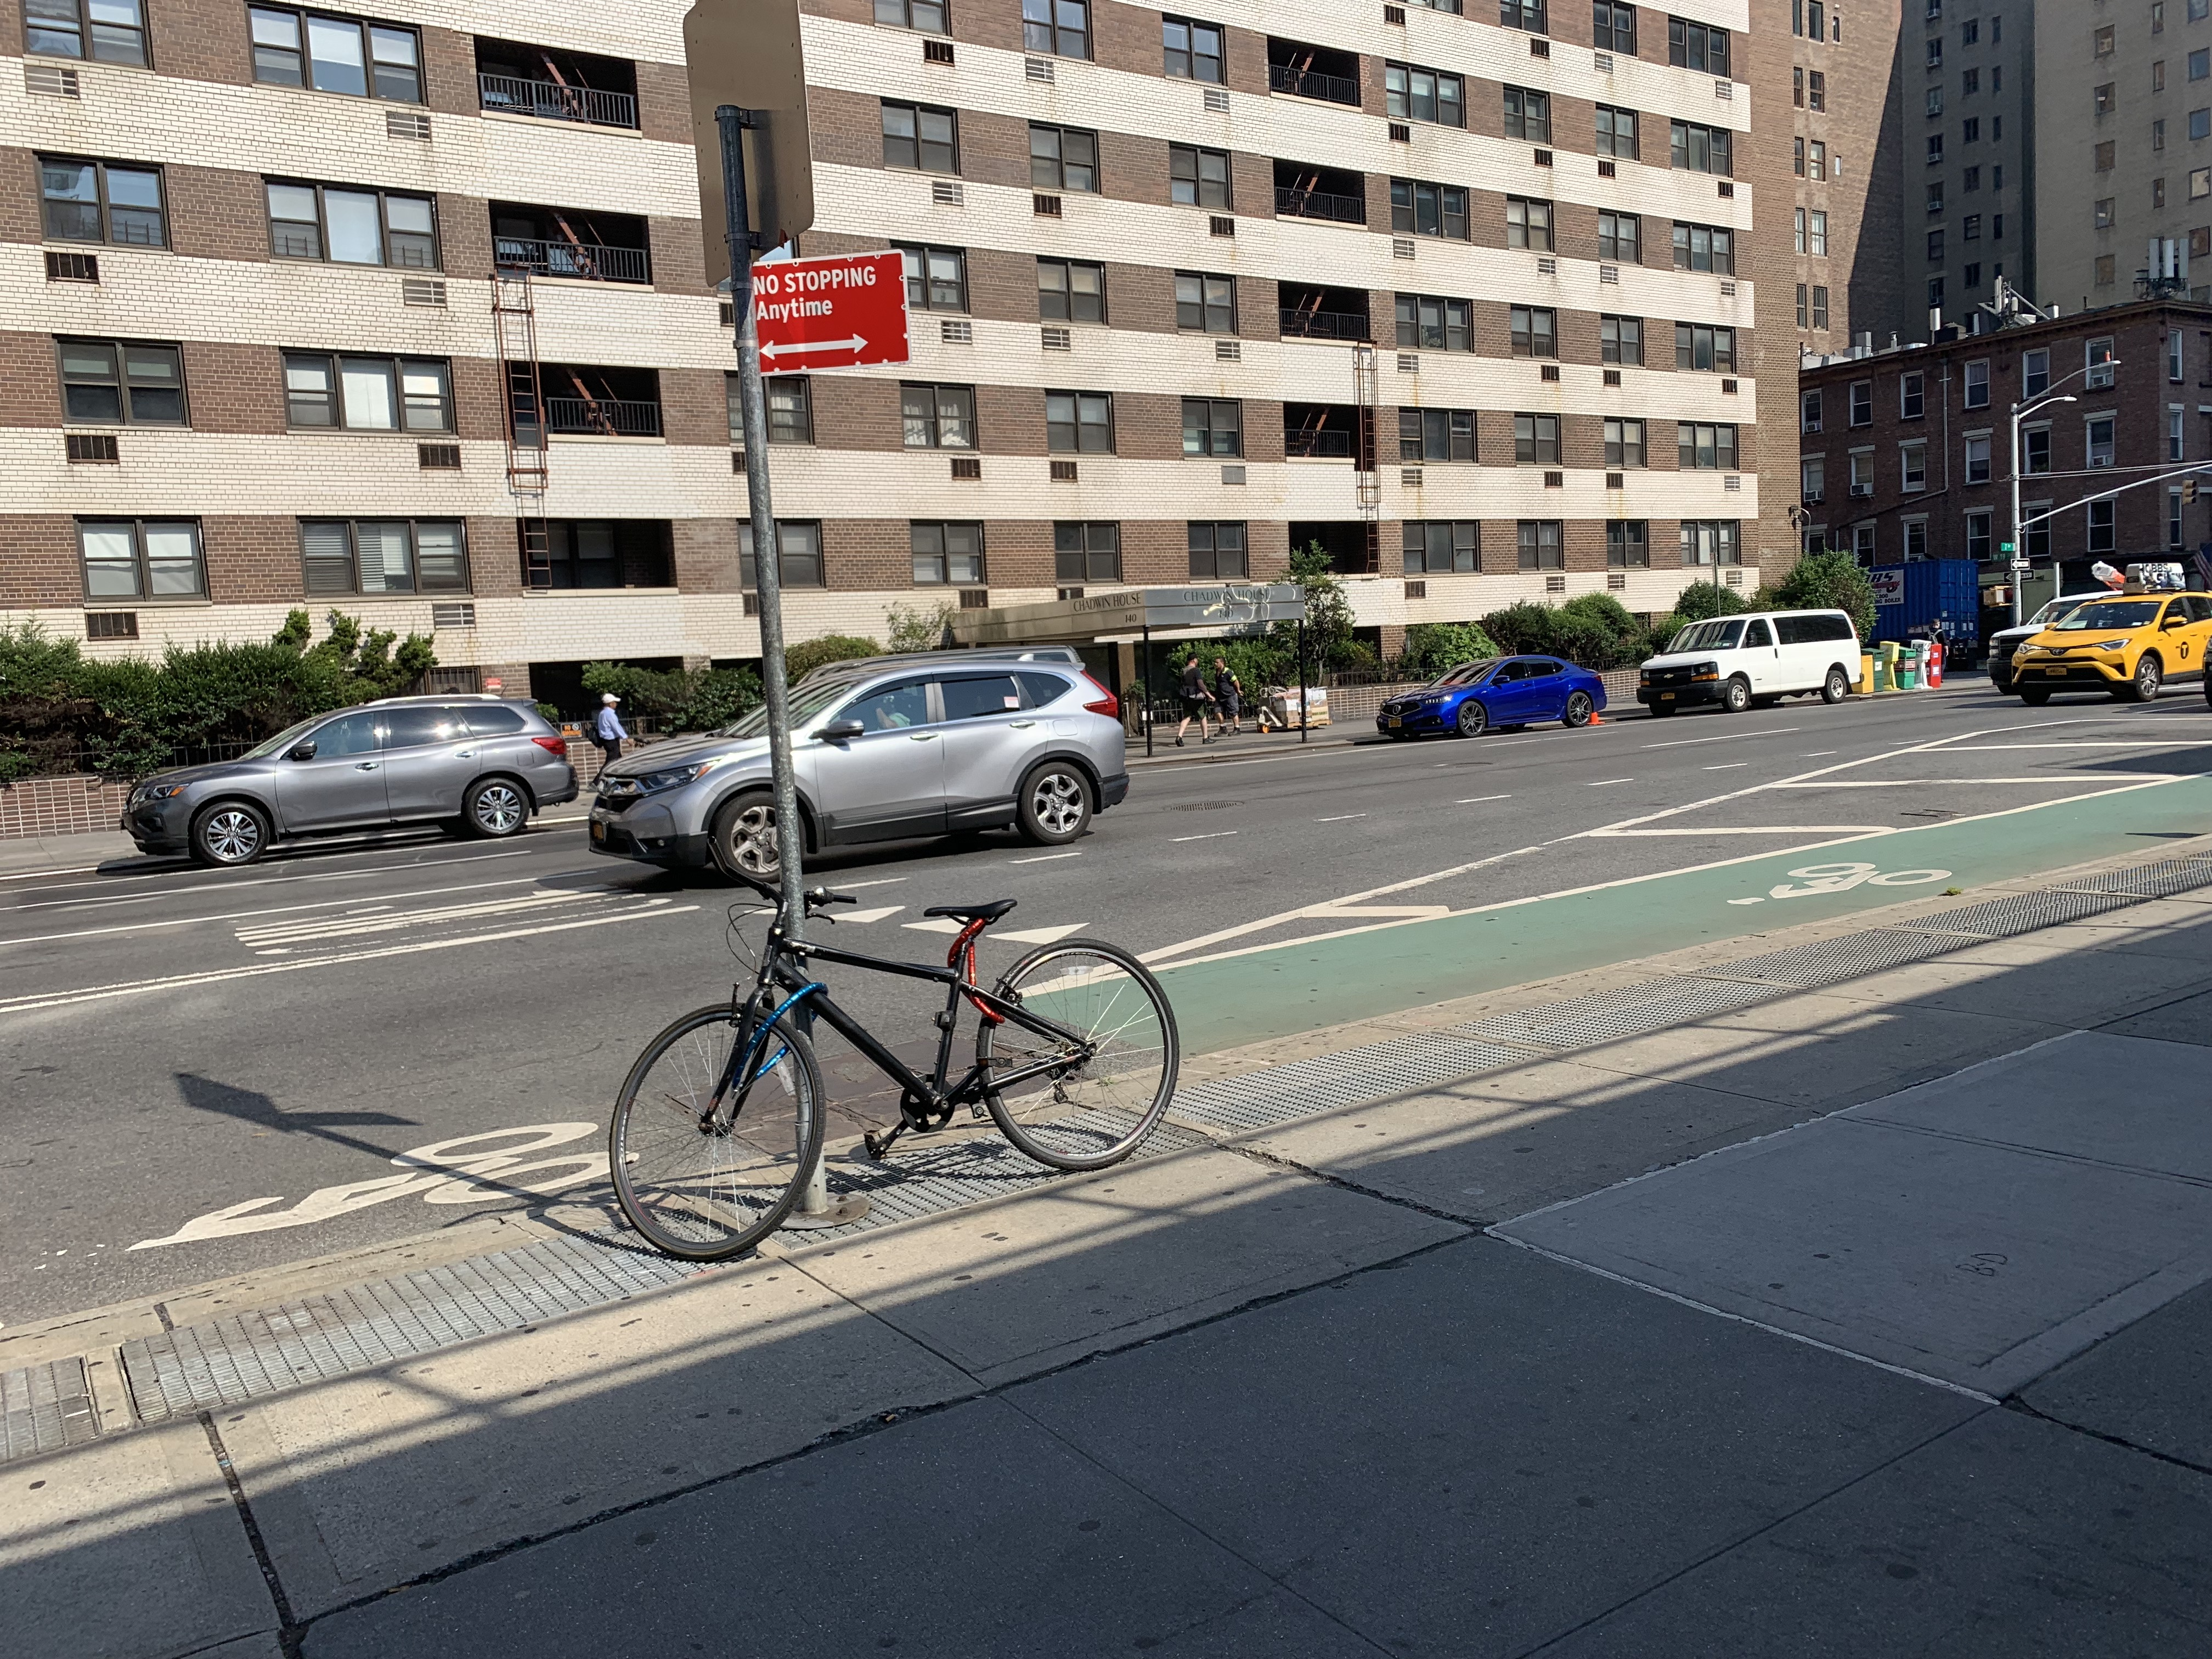

In [14]:
Show(filename='bikes_data/1/IMG_1494.JPG')

In [22]:
Video('bikes_data/IMG_1521.MOV')

Now we need to load in data in a format that's ready for the training code. We do that with fast.ai's data block.

In [28]:
data_path = Path('./bikes_data') ## The path for our data
save_path = Path('./bikes_data') ## The path where we save things (it's the same for now)

data = (ImageList.from_folder(data_path)  #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()         #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()         #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(), size=224)  #Data transforms applied, size of images shrink to 224
        .databunch(bs=16))

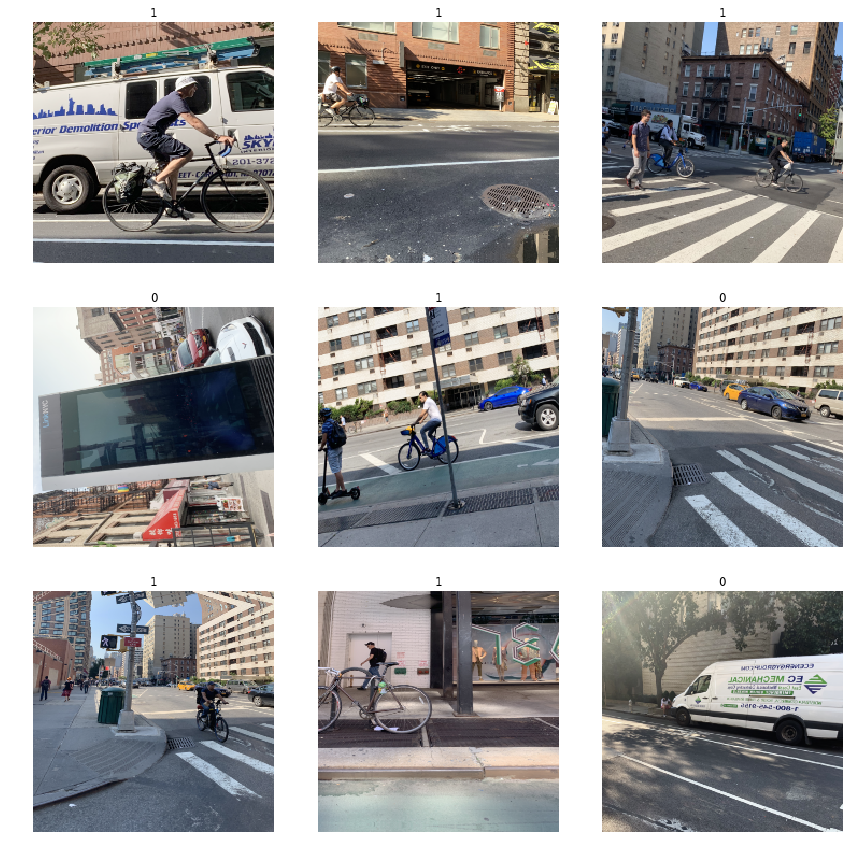

In [29]:
data.show_batch(rows=3)

## Training

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Most people don't! For a deeper dive, check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: 0 and 1

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning."

First we load our data and `model.resnet34` together into a training model known as a "learner."

In [30]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We will train for 4 epochs (4 cycles through all our data).

In [31]:
learn.fit_one_cycle(4)

### How are we doing?
So far, we have an error rate of 7% ... which isn't bad!

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not.

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

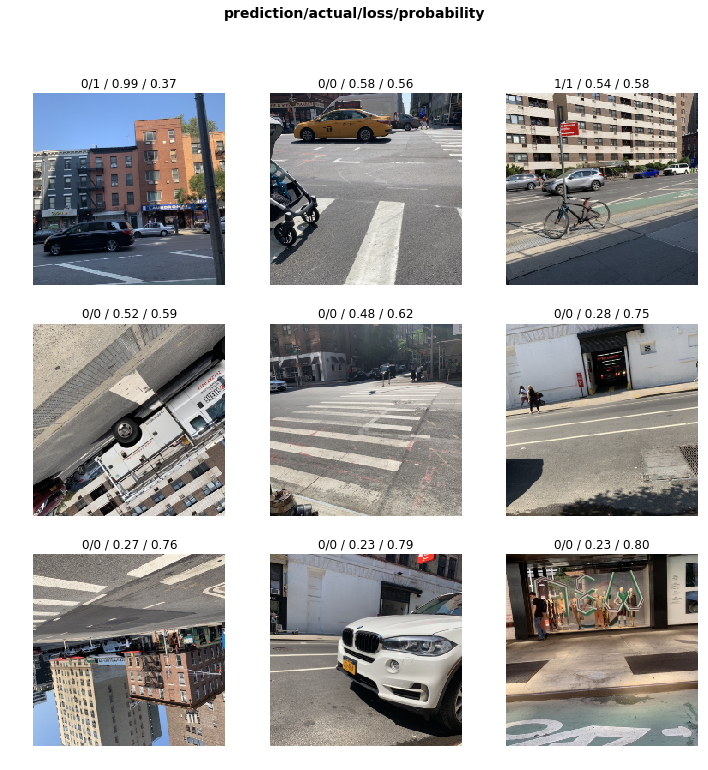

In [34]:
interp.plot_top_losses(9)

We can also see the situations in which it was most confused:

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's save what we have in case we mess it up later!

In [ ]:
learn.save(save_path + 'bikes-1')

### Fine tuning

So these results are already pretty fantastic, but we might be able to do even better. We can "unfreeze" part of the model we have to actually infuse the original model with our new training images. Let's try.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2)

We can also adjust the "learning rate" -- which is an adjustment in the size of the "steps" taken to find the best answers during training. You can imagine that taking steps that are too small may take too long to get to the answer and taking steps that are too big might overshoot the best answer. 

Here's how we find the ideal "learning rate" in fast.ai:

In [ ]:
learn.lr_find()

Then ...

In [ ]:
learn.recorder.plot(suggestion=True)

Let's try to use that learning rate ...

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Save those results!

In [ ]:
learn.save(save_path + 'bikes-2')

We're also going to _export_ the entire package as a "pickle" file called `export.pkl`

**Warning for Google Colab users!** Later, when you've done more fine tuning and what you've done, you need to give permission for this notebook to write files to your Google Drive. In that case, you'll want to run the next cell and follow the permission-granting steps. For now, you can skip this.

In [ ]:
## THIS CELL WILL ALLOW GOOGLE COLAB USERS SAVE MODELS TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
save_path = Path(root_dir + 'ai-bikes/')
save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
learn.export(save_path + "export.pkl")

## Search our video

Now we'll apply our model to our video! First we need to turn the video into a bunch of images using `ffmpeg`.